<a href="https://colab.research.google.com/github/XingshengWei233/GAN_on_MNIST/blob/main/GAN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GANs : Generative Adversarial Networks 
This is a class project that uses GAN to generate 28 x 28 image in MNIST style


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)



## Model Definition (TODO)

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()

        ################################
        # Please fill in your code here:
        ################################
        self.main = nn.Sequential(

            nn.ConvTranspose2d(100, 28*2, 10,2,bias=False),
            nn.BatchNorm2d(28*2),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(28*2, 1, 10, 2, bias=False),
            nn.Tanh()

        )


    def forward(self, input):

        ################################
        # Please fill in your code here:
        ################################
        out = self.main(input)
        # Explain why Tanh is needed for the last layer
        # Use tanh to get a output of each pixle of 1 or -1, while keeping the gradient existing
        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:
        ################################
        self.main1 = nn.Sequential(
                
            nn.Conv2d(1, 28, 4,bias=False),
            nn.BatchNorm2d(28),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(28, 28*2, 4,bias=False),
            nn.BatchNorm2d(28 * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.main2 = nn.Sequential(
            nn.Linear(27104,1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        

        ################################
        # Please fill in your code here:
        ################################
        out = self.main1(input)
        out = torch.flatten(out,1)
        out = self.main2(out)

        # Explain why Sigmoid is needed for the last layer
        # Use sigmoid to get a output of 0 or 1, while keeping the gradient existing
        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


GAN loss (TODO)

In [ ]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    ################################
    # Please fill in your code here:
    ################################
    D_out_real = D(real)
    loss_real = criterion(D_out_real,Valid_label)

    fake_imgs = G(noise)
    D_out_fake = D(fake_imgs)
    loss_fake = criterion(D_out_fake.detach(),Fake_label)

    loss_D = loss_real+loss_fake

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    
    ################################
    # Please fill in your code here:
    ################################
    D_out_fake = netD(fake)
    loss_G = criterion(D_out_fake,Valid_label)
    return loss_G

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 56, 10, 10]         560,000
       BatchNorm2d-2           [-1, 56, 10, 10]             112
              ReLU-3           [-1, 56, 10, 10]               0
   ConvTranspose2d-4            [-1, 1, 28, 28]           5,600
              Tanh-5            [-1, 1, 28, 28]               0
Total params: 565,712
Trainable params: 565,712
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 2.16
Estimated Total Size (MB): 2.30
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 25, 25]             448
       BatchNorm2d-2           [-1, 

TRAINING

[0/10][0/600]	Loss_D: 1.0505	Loss_G: 0.7441	
[0/10][50/600]	Loss_D: 0.0636	Loss_G: 3.4268	
[0/10][100/600]	Loss_D: 0.0183	Loss_G: 4.5597	
[0/10][150/600]	Loss_D: 0.0254	Loss_G: 4.1224	
[0/10][200/600]	Loss_D: 0.2799	Loss_G: 2.0559	
[0/10][250/600]	Loss_D: 0.3983	Loss_G: 1.5645	
[0/10][300/600]	Loss_D: 0.4175	Loss_G: 1.7743	
[0/10][350/600]	Loss_D: 0.4958	Loss_G: 1.3047	
[0/10][400/600]	Loss_D: 0.5786	Loss_G: 1.1202	
[0/10][450/600]	Loss_D: 0.6005	Loss_G: 1.3481	
[0/10][500/600]	Loss_D: 0.5180	Loss_G: 1.6161	
[0/10][550/600]	Loss_D: 0.5404	Loss_G: 1.1696	
[1/10][0/600]	Loss_D: 0.5844	Loss_G: 2.8181	
[1/10][50/600]	Loss_D: 0.6725	Loss_G: 0.9786	
[1/10][100/600]	Loss_D: 0.5987	Loss_G: 1.2711	
[1/10][150/600]	Loss_D: 0.4690	Loss_G: 1.5221	
[1/10][200/600]	Loss_D: 0.4520	Loss_G: 2.2261	
[1/10][250/600]	Loss_D: 0.4595	Loss_G: 1.6395	
[1/10][300/600]	Loss_D: 0.5713	Loss_G: 1.1841	
[1/10][350/600]	Loss_D: 0.4859	Loss_G: 1.3019	
[1/10][400/600]	Loss_D: 0.4741	Loss_G: 1.4274	
[1/10][450/600]	Los

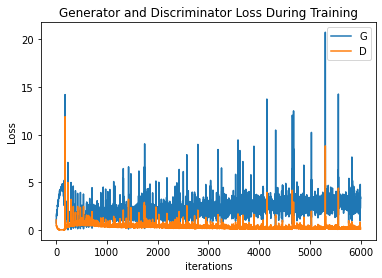

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10 #10

CUDA_LAUNCH_BLOCKING=1
  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        Valid_label = Valid_label[:, None]
        Fake_label = Fake_label[:, None]
        optimizerD.zero_grad()
        result_D = torch.log(netD(real)) + torch.log(1 - netD(netG(noise)))
        result_D = torch.mean(result_D)
        result_D = -result_D

        result_D.backward()
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        optimizerG.zero_grad()
        result_G = torch.log(netD(netG(noise)))
        result_G = torch.mean(result_G)
        result_G = -result_G
        result_G.backward()
        optimizerG.step()

        loss_D,fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
        loss_G= loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(gan_train_loader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## Qualitative Visualisations

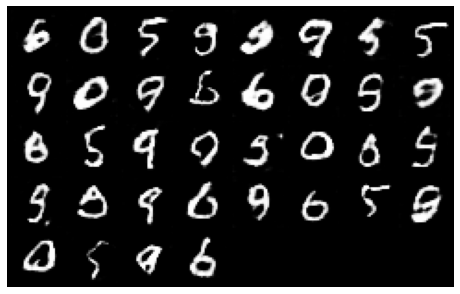

In [ ]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())